# Importing Libraries


In [1]:
from wfield import *
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import h5py
from scipy.ndimage import label
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator



# Defining functions

In [68]:
def extract_trial_data(bpod_data, states_list):
    trials = bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0, 0]

    # Lists to hold the data
    num_trials = []
    trial_types = []
    outcomes = []

    # Loop through each trial
    for trial in range(trials.shape[1]):
        trial_data = trials[0, trial]
        trial_type = bpod_data['SessionData'][0, 0]['TrialTypes'][0, trial]
        states = trial_data['States'][0, 0]  # Adjust according to your data structure
        outcome = None  # Initialize outcome as None

        # Determine the outcome based on the states
        for state in states_list:
            if not np.isnan(states[state][0, 0]).any():  # Check for valid state data
                if state == 'Hit':
                    outcome = 2
                elif state == 'Anticipatory_Hit':
                    outcome = 1
                elif state == 'Miss':
                    outcome = -1
                elif state == 'Anticipatory_Miss':
                    outcome = 0
                break  # Exit loop once a valid state is found

        if outcome is None:
            print("No valid state found for trial", trial + 1)

        # Append data to the lists
        num_trials.append(trial + 1)
        trial_types.append(trial_type)
        outcomes.append(outcome)

    return num_trials, trial_types, outcomes

# Example usage:
# bpod_data = <your_bpod_data>  # Replace with your actual data
# states_list = ['Hit', 'Anticipatory_Hit', 'Miss', 'Anticipatory_Miss']
# 


In [2]:
# def list_scans(data_folder, keyword):
#     # Find folders containing the keyword
#     scan_folders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder)) and keyword in folder]

#     # Print list of found folders
#     print(f"Folders containing '{keyword}' keyword:")
#     for i, folder in enumerate(scan_folders):
#         print(f"{i + 1}. {folder}")

#     # Prompt user to choose a folder
#     while True:
#         choice = input("Enter the number of the scan you want to choose: ")
#         if choice.isdigit() and 1 <= int(choice) <= len(scan_folders):
#             chosen_folder = scan_folders[int(choice) - 1]
#             break
#         else:
#             print("Invalid input. Please enter a valid number.")
#     print("Selected",chosen_folder)
#     # Return the path to the chosen folder
#     return os.path.join(data_folder, chosen_folder), chosen_folder


In [3]:
# import os

def list_scans(data_folder, keyword):
    # Find folders containing the keyword and get their creation time
    scan_folders = [(folder, os.stat(os.path.join(data_folder, folder)).st_ctime) for folder in os.listdir(data_folder) 
                    if os.path.isdir(os.path.join(data_folder, folder)) and keyword in folder]

    # Sort folders by creation time, newest first
    scan_folders.sort(key=lambda x: x[1], reverse=True)

    # Extract folder names for display
    scan_folder_names = [folder[0] for folder in scan_folders]

    # Print list of found folders
    print(f"Folders containing '{keyword}' keyword:")
    for i, folder in enumerate(scan_folder_names):
        print(f"{i + 1}. {folder}")

    # Prompt user to choose a folder
    while True:
        choice = input("Enter the number of the scan you want to choose: ")
        if choice.isdigit() and 1 <= int(choice) <= len(scan_folder_names):
            chosen_folder = scan_folder_names[int(choice) - 1]
            break
        else:
            print("Invalid input. Please enter a valid number.")
    
    print("Selected", chosen_folder)
    # Return the path to the chosen folder
    return os.path.join(data_folder, chosen_folder), chosen_folder


In [4]:
def demultiplex(auxdata, channels=5):
    """Demultiplex the digital data"""
    auxdata = auxdata.flatten()
    binary = [[int(x) for x in f'{x:0{channels}b}'] for x in auxdata]
    return np.array(binary, dtype=bool).T

In [5]:
def find_event_sizes(signal):
    event_sizes = []
    event_positions = []
    trialON_idx = []
    rewards_idx = []
    event_start = None

    for i, val in enumerate(signal):
        if val == 1 and event_start is None:
            event_start = i
        elif val == 0 and event_start is not None:
            event_duration = i - event_start
            event_sizes.append(event_duration)
            if event_duration > 10:
                rewards_idx.append((event_start, i))
            else:
                trialON_idx.append((event_start, i))
            # event_positions.append((event_start, i))
            event_start = None

    if event_start is not None:  # Handle case where the last event goes till the end
        event_duration = len(signal) - event_start
        event_sizes.append(event_duration)
        event_positions.append((event_start, len(signal)))
    
    return event_sizes, trialON_idx,rewards_idx

In [6]:
def list_bpod(localdisk):
    import scipy.io
    mat_files = glob(pjoin(localdisk,'*.mat'))
    if len(mat_files) > 1:
        print("Multiple Bpod files found:")
        for i, mat_file in enumerate(mat_files):
            print(f"{i + 1}. {os.path.basename(mat_file)}")
        
        while True:
            choice = input("Enter the number of the .dat file you want to choose: ")
            if choice.isdigit() and 1 <= int(choice) <= len(mat_files):
                mat_path = mat_files[int(choice) - 1]
                break
            else:
                print("Invalid input. Please enter a valid number.")
    elif len(mat_files) == 1:
        mat_path = mat_files[0]
        print("Bpod file found")
        print("Loading...")
    else:
        print("Bpod file not found")
        print("-----------------------")
    
    try:
        bpod_data = scipy.io.loadmat(mat_path)
        print("Selected", os.path.basename(mat_path))
    except:
        print("Failed")
    return bpod_data


In [7]:
# Load the HDF5 file and read the necessary datasets
def load_h5_data(h5_path):
    with h5py.File(h5_path, 'r') as f:
        sweep_data_key = list(f.keys())[1]
        sweep_data = f[sweep_data_key]
        header = f['header']

        AIChannelNames = header['AIChannelNames'][:]
        DIChannelNames = header['DIChannelNames'][:]
        YLimitsPerAIChannel = header['YLimitsPerAIChannel'][:]
        AIChannelNames = [name.decode('utf-8') for name in AIChannelNames]
        DIChannelNames = [name.decode('utf-8') for name in DIChannelNames]
        SampleRate = header['AcquisitionSampleRate'][:]

        analogData = sweep_data['analogScans'][:]
        digitalData = sweep_data['digitalScans'][:]

        return AIChannelNames, DIChannelNames, SampleRate[0, 0], analogData, digitalData

# Convert analogData and digitalData to DataFrame
def create_dataframe(ai_channel_names, di_channel_names, sample_rate, analog_data, digital_data):
    # Create DataFrame for analog data
    df_analog = pd.DataFrame(analog_data.T, columns=ai_channel_names)

    # Create DataFrame for digital data
    df_digital = pd.DataFrame(digital_data.T, columns=di_channel_names)

    # Concatenate analog and digital data
    df = pd.concat([df_analog, df_digital], axis=1)

    # Add time column
    df['time_seconds'] = df.index / sample_rate

    return df

In [8]:
def extract_trials(data, idx_list, pre_window, post_window):
    trials = []
    for start, end in idx_list:
        trial_start = max(0, start - pre_window)
        trial_end = min(len(data), end + post_window)
        trial_data = data[trial_start:trial_end]
        trials.append(trial_data)
    return trials

# Reading Aux file

In [17]:
data_folder = r'/datajoint-data/data/aeltona/'
localdisk, scan_idx = list_scans(data_folder,"AA")

Folders containing 'AA' keyword:
1. AA_ROS-1839_2024-07-27_scan9FPBWRXK_sess9FPBWRXK
2. AA_ROS-1839_2024-07-20_scan9FP7QCXR_sess9FP7QCXR
3. AA_ROS-1706_2024-03-12_scan9FN2ANVG_sess9FN2ANVG
4. Oddball_AA_ROS-1706_2024-03-12_scan9FN2BCOS_sess9FN2ANVG
5. AA_ROS-1844_2024-07-27_scan9FPBXWYJ_sess9FPBXWYJ
6. AA_ROS-1842_2024-07-27_scan9FPBYS0V_sess9FPBYS0V
7. AA_ROS-1844_2024-07-28_scan9FPCHT9G_sess9FPCHT9G
8. AA_ROS-1839_2024-07-28_scan9FPCIPC2_sess9FPCIPC2
9. AA_ROS-1842_2024-07-28_scan9FPCJIBD_sess9FPCJIBD
10. AA_ROS-1844_2024-07-26_scan9FPB82HK_sess9FPB82HK
11. AA_ROS-1839_2024-07-26_scan9FPB9CD7_sess9FPB9CD7
12. AA_ROS-1844_2024-07-26_scan9FPB8EK6_sess9FPB82HK
13. AA_ROS-1842_2024-07-26_scan9FPBA5JI_sess9FPBA5JI
14. AA_ROS-1844_2024-07-25_scan9FPAQTAG_sess9FPAQTAG
15. AA_ROS-1839_2024-07-25_scan9FPAPOQF_sess9FPAPOQF
16. AA_ROS-1842_2024-07-25_scan9FPARK9E_sess9FPARK9E
17. AA_ROS-1842_2024-07-24_scan9FPA2W09_sess9FPA2W09
18. AA_ROS-1844_2024-07-24_scan9FPA3VYT_sess9FPA3VYT
19. AA_ROS-183

In [10]:
h5_path = glob(pjoin(localdisk,'*.h5'))[0]
h5_path

'/datajoint-data/data/aeltona/AudPassCond_AA_ROS-1792_2024-06-15_scan9FOMVTU6_sess9FOMVAUF/scan9FOMVTU6_AudPassCond_AudPassCond_AA_ROS-1792_0001.h5'

In [13]:

# Open the HDF5 file
with h5py.File(h5_path, 'r') as f:
    sweep_data_key = list(f.keys())[1]
    # print(sweep_data_key)
    sweep_data = f[sweep_data_key]
    # print(sweep_data.keys())
    header = f['header'] 
    # print(header.keys())    
    AIChannelNames = header['AIChannelNames'][:]
    DIChannelNames = header['DIChannelNames']
    DIChannelTerminalIDs = header['DIChannelTerminalIDs'][:]
    YLimitsPerAIChannel = header['YLimitsPerAIChannel'][:]
    AIChannelNames = [name.decode('utf-8') for name in AIChannelNames]
    DIChannelNames = [name.decode('utf-8') for name in DIChannelNames]
    SampleRate = header['AcquisitionSampleRate'][:]
    analogData = sweep_data['analogScans'][:]
    digitalData = sweep_data['digitalScans'][:]

In [14]:
DIChannelNames

['FakeReward', 'VisStim_ON']

In [15]:
sampling_rate_hz = int(SampleRate[0,0])


In [16]:
# Convert analogData to DataFrame
df = pd.DataFrame(analogData.T, columns=AIChannelNames)
sampling_rate_hz = int(SampleRate[0,0])
df['time_seconds'] = df.index / sampling_rate_hz
# Print DataFrame
# print(df)
df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'HIFI', 'Reward',
       'TrialTypeON', 'Licks', 'Rotary Encoder', 'time_seconds'],
      dtype='object')

## Digital channels

In [17]:
DIChannelNames

['FakeReward', 'VisStim_ON']

In [18]:
digital_scans = demultiplex(digitalData[0], len(DIChannelNames))


In [19]:
digital_scans.shape

(2, 69088640)

In [34]:
df[DIChannelNames[0]] = digital_scans[1]
df[DIChannelNames[1]] = digital_scans[0]

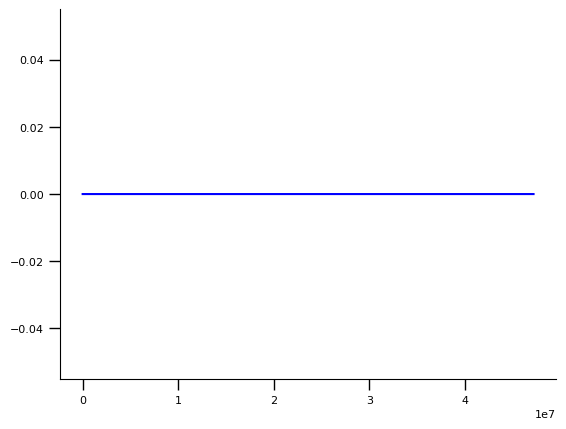

In [33]:
# df['HIFI_norm']= df["HIFI"] / df["HIFI"].max()

# plt.plot(digital_scans[0],c="blue");
# plt.plot(digital_scans[1],c='red');
# plt.plot(df['HIFI_norm'],c='black');
# plt.plot(digital_scans[1]);

## Licks

In [16]:
norm_TrialON_FRew = (df['TrialON_FRew'] - df['TrialON_FRew'].min()) / (df['TrialON_FRew'].max() - df['TrialON_FRew'].min())
norm_TrialON_FRew = norm_TrialON_FRew.round(0)
norm_Rew_StimON = (df['Reward'] - df['Reward'].min()) / (df['Reward'].max() - df['Reward'].min())
norm_Rew_StimON = norm_Rew_StimON.round(0)
norm_licks = (df['Lick Count'] - df['Lick Count'].min()) / (df['Lick Count'].max() - df['Lick Count'].min())
norm_licks = norm_licks.round(0)

In [35]:

try:
    norm_TrialON_FRew = (df['TrialON_FRew'] - df['TrialON_FRew'].min()) / (df['TrialON_FRew'].max() - df['TrialON_FRew'].min())
    norm_TrialON_FRew = norm_TrialON_FRew.round(0)
    norm_Rew_StimON = (df['Rew_StimON'] - df['Rew_StimON'].min()) / (df['Rew_StimON'].max() - df['Rew_StimON'].min())
    norm_Rew_StimON = norm_Rew_StimON.round(0)
    norm_licks = (df['Lick Count'] - df['Lick Count'].min()) / (df['Lick Count'].max() - df['Lick Count'].min())
    norm_licks = norm_licks.round(0)
except:
    # norm_TrialON_FRew = (df['FakeReward'] - df['FakeReward'].min()) / (df['FakeReward'].max() - df['FakeReward'].min())
    # try:
        norm_TrialON_FRew = df['FakeReward']
        norm_licks = (df['Licks'] - df['Licks'].min()) / (df['Licks'].max() - df['Licks'].min())
        norm_licks = norm_licks.round(0)
    # except:
        norm_Rew_StimON = (df['Reward'] - df['Reward'].min()) / (df['Reward'].max() - df['Reward'].min())
        norm_Rew_StimON = norm_Rew_StimON.round(0)
        


In [36]:
event_sizes, trialON_idx, rews_idx  = find_event_sizes(norm_Rew_StimON)

print("Event sizes:", np.unique(event_sizes))
print("Length of trialON_idx:", len(trialON_idx))
print("Length of rews_idx:", len(rews_idx))

Event sizes: [5250]
Length of trialON_idx: 0
Length of rews_idx: 20


In [37]:
event_sizes, trialON_idx, frews_idx  = find_event_sizes(norm_TrialON_FRew)

print("Event sizes:", np.unique(event_sizes))
print("Length of trialON_idx:", len(trialON_idx))
print("Length of frews_idx:", len(frews_idx))

Event sizes: [5250 5251]
Length of trialON_idx: 0
Length of frews_idx: 85


In [38]:
# Create arrays for trial onsets and rewards
trial_onsets = np.zeros_like(norm_TrialON_FRew)
frews = np.zeros_like(norm_TrialON_FRew)
rews = np.zeros_like(norm_Rew_StimON)

for start, end in trialON_idx:
    trial_onsets[start:end] = 1

for start, end in frews_idx:
    frews[start:end] = 1

for start, end in rews_idx:
    rews[start:end] = 1

In [39]:
pre_window = int(5 * sampling_rate_hz)  # 5 seconds before
post_window = int(10 * sampling_rate_hz)  # 10 seconds after

frews_trials = extract_trials(norm_licks, frews_idx, pre_window, post_window)
rews_trials = extract_trials(norm_licks, rews_idx, pre_window, post_window)


In [40]:
filename_parts = re.split(r'_|\.', scan_idx)
scan_info = '_'.join(filename_parts[0:5])
scan_info

'Habituation_AA_ROS-1792_2024-06-04_scan9FOG9RQH'

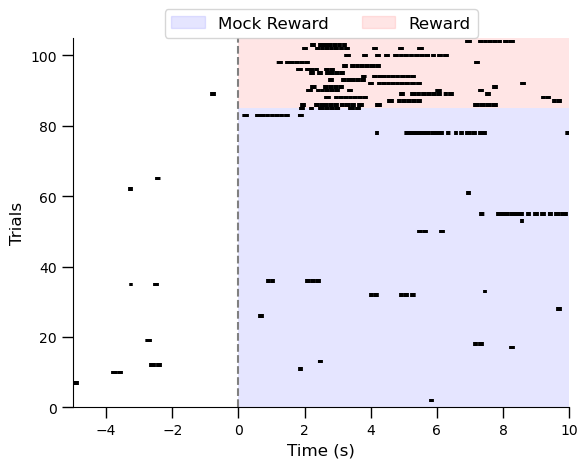

In [42]:
# Constants for time adjustment
pre_time_seconds = 5  # 5 seconds before the onset
post_time_seconds = 10  # 10 seconds after the onset

# Convert these times to index offsets
pre_index = pre_time_seconds * sampling_rate_hz
post_index = post_time_seconds * sampling_rate_hz

# Calculate total number of points to display
total_points = pre_index + post_index

# Adjust pre_window and post_window according to the onset index and total points
pre_window = 100000 - pre_index  # Adjusted to start 5s before the onset
post_window = 100000 + post_index  # Adjusted to end 10s after the onset

# Time conversion for x-axis (from indices to seconds, centered at onset)
time_axis = np.linspace(-pre_time_seconds, post_time_seconds, total_points)

# Adjust event plotting to reflect new time_axis
for i, trial in enumerate(frews_trials):
    events = np.where(trial)[0]
    valid_events = events[(events >= pre_window) & (events < post_window)] - 100000
    plt.eventplot(time_axis[valid_events + pre_index], lineoffsets=i, colors='black')

offset = len(frews_trials)
for i, trial in enumerate(rews_trials):
    events = np.where(trial)[0]
    valid_events = events[(events >= pre_window) & (events < post_window)] - 100000
    plt.eventplot(time_axis[valid_events + pre_index], lineoffsets=i + offset, colors='black')


num_frews_trials = len(frews_trials)
num_rews_trials = len(rews_trials)
total_trials = num_frews_trials + num_rews_trials

# Shading for frews_trials
for i in range(num_frews_trials):
    ymin = i / total_trials  # Adjust ymin based on total trials count
    ymax = (i + 1) / total_trials  # Adjust ymax similarly
    plt.axvspan(0, 10, facecolor='blue', alpha=0.1, ymin=ymin, ymax=ymax)

# Shading for rews_trials
for i in range(num_rews_trials):
    ymin = (i + num_frews_trials) / total_trials  # Start from the end of frews_trials
    ymax = (i + 1 + num_frews_trials) / total_trials
    plt.axvspan(0, 10, facecolor='red', alpha=0.1, ymin=ymin, ymax=ymax)

mock_reward_patch = patches.Patch(color='blue', alpha=0.1, label='Mock Reward')
reward_patch = patches.Patch(color='red', alpha=0.1, label='Reward')

# Update formatting
plt.xlabel('Time (s)')
plt.ylabel('Trials')
# plt.title('Raster Plot of Lick Events')
plt.axvline(0, color='grey', linestyle='--')  # Indicate the stimulus onset
plt.xlim([-5, 10])  # Set x-axis limits to -5s to 10s
plt.ylim(0,total_trials)

# Adjust tick label size
plt.xticks(fontsize=10)  # Adjust tick font size as needed
plt.yticks(fontsize=10)  # Adjust tick font size as needed

plt.legend(handles=[mock_reward_patch, reward_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

# Construct the path to the folder where the plot will be saved
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Licks')
file_path = os.path.join(folder_path, f'{scan_info}_licks')

# Check if the folder exists, and create it if it does not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(f'{file_path}.svg')
plt.savefig(f'{file_path}.png')
plt.show()

In [ ]:
df['trial_onsets'] = trial_onsets
df['norm_licks'] = norm_licks
df['rews'] = rews
df['frews'] = frews
df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'HIFI', 'Rew_StimON',
       'TrialON_FRew', 'Lick Count', 'Rotary Encoder', 'time_seconds',
       'trial_onsets', 'norm_licks', 'rews', 'frews'],
      dtype='object')

# Reading Bpod Data


In [357]:
data_folder = r'/datajoint-data/data/aeltona/'
localdisk, scan_idx = list_scans(data_folder,"AA_ROS-1839")

Folders containing 'AA_ROS-1839' keyword:
1. AA_ROS-1839_2024-07-24_scan9FPA4ZYH_sess9FPA4ZYH
2. AA_ROS-1839_2024-07-27_scan9FPBWRXK_sess9FPBWRXK
3. AA_ROS-1839_2024-07-20_scan9FP7QCXR_sess9FP7QCXR
4. AA_ROS-1839_2024-07-28_scan9FPCIPC2_sess9FPCIPC2
5. AA_ROS-1839_2024-07-26_scan9FPB9CD7_sess9FPB9CD7
6. AA_ROS-1839_2024-07-25_scan9FPAPOQF_sess9FPAPOQF
7. AA_ROS-1839_2024-07-23_scan9FP9IRC2_sess9FP9IRC2
8. AA_ROS-1839_2024-07-22_scan9FP8YFUZ_sess9FP8YFUZ
9. AA_ROS-1839_2024-07-19_scan9FP76RKO_sess9FP76RKO
10. AA_ROS-1839_2024-07-21_scan9FP8DS2O_sess9FP8DS2O
11. AA_ROS-1839_2024-07-18_scan9FP6K8FK_sess9FP6K8FK
Selected AA_ROS-1839_2024-07-27_scan9FPBWRXK_sess9FPBWRXK


In [358]:
bpod_data = list_bpod(localdisk)

Multiple Bpod files found:
1. ROS-1839_SensoryPreconditioning_20240727_201357.mat
2. scan9FPBWRXK_ROS-1839_SensoryPreconditioning_20240727_204958.mat
Selected ROS-1839_SensoryPreconditioning_20240727_201357.mat


In [359]:
two_sessions = True

# Outcome plot

In [360]:
states_list = ['Hit', 'Anticipatory_Hit','Miss','Anticipatory_Miss']
num_trials, trial_types, outcomes = extract_trial_data(bpod_data, states_list)


In [361]:
# Create the DataFrame
outcome_df = pd.DataFrame({
    'num_trial': num_trials,
    'trial_type': trial_types,
    'outcome': outcomes
})

display(outcome_df[-5:])
first_session = outcome_df

,num_trial,trial_type,outcome
153,154,2,1
154,155,1,2
155,156,2,-1
156,157,2,-1
157,158,1,2


In [362]:
if two_sessions:
    print("Choose SECOND bpod session")
    bpod_data = list_bpod(localdisk)
    states_list = ['Hit', 'Anticipatory_Hit','Miss','Anticipatory_Miss']
    num_trials, trial_types, outcomes = extract_trial_data(bpod_data, states_list)
    last_trial = first_session['num_trial'].max()
    # Create the DataFrame
    second_session = pd.DataFrame({
        'num_trial': [trial+last_trial for trial in num_trials],
        'trial_type': trial_types,
        'outcome': outcomes
    })

    display(second_session[-5:])
    outcome_df = pd.concat([first_session, second_session], ignore_index=True)
    display(outcome_df[-5:])

else:
    print("Only one bpod session")
    outcome_df = first_session
    display(outcome_df[-5:])



Choose SECOND bpod session
Multiple Bpod files found:
1. ROS-1839_SensoryPreconditioning_20240727_201357.mat
2. scan9FPBWRXK_ROS-1839_SensoryPreconditioning_20240727_204958.mat
Selected scan9FPBWRXK_ROS-1839_SensoryPreconditioning_20240727_204958.mat


,num_trial,trial_type,outcome
20,179,2,1
21,180,1,0
22,181,2,1
23,182,2,1
24,183,2,-1


,num_trial,trial_type,outcome
178,179,2,1
179,180,1,0
180,181,2,1
181,182,2,1
182,183,2,-1


In [363]:
filename_parts = re.split(r'_|\.', scan_idx)
scan_info = '_'.join(filename_parts[0:5])
scan = filename_parts[-2]
mouse = filename_parts[1]
date = filename_parts[2]
cohort = 1
task = 'PassVisCond' #filename_parts[0]



folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
file_path = os.path.join(folder_path, f'learning_df.csv')
learning_df = pd.read_csv(file_path)
# # Create a new dataframe for learning_df
# learning_df = pd.DataFrame({
#     'Mouse': [mouse],
#     'Date': [date],
#     'Task': [task],
#     'Scan': [scan]
# })

display(learning_df)
print(f'scan: {scan}')
print(f'mouse: {mouse}')
print(f'date: {date}')
print(f'task: {task}')
print(f'cohort: {cohort}')


,Mouse,Date,Task,True Task,Mode,Scan,Miss %,FA %,Hit %,CR %,Date_Task,Cohort,Training Day
0,ROS-1783,2024-06-08,PassVisCond,Visual Conditioning,Passive,scan9FOIPM7X,23.157895,8.421053,2.105263,66.315789,2024-06-08 / PassVisCond,1,1.0
1,ROS-1783,2024-06-09,PassVisCond,Visual Conditioning,Passive,scan9FOJAPFP,17.948718,19.230769,51.282051,11.538462,2024-06-09 / PassVisCond,1,2.0
2,ROS-1792,2024-06-10,PassVisCond,Visual Conditioning,Passive,scan9FOJVAWJ,31.132075,11.320755,3.773585,53.773585,2024-06-10 / PassVisCond,1,1.0
3,ROS-1783,2024-06-10,AtivVisCond,Visual Conditioning,Active,scan9FOJU4V9,0.000000,19.354839,51.612903,29.032258,2024-06-10 / AtivVisCond,1,3.0
4,ROS-1792,2024-06-11,PassVisCond,Visual Conditioning,Passive,scan9FOKEEYA,10.810811,10.810811,21.621622,56.756757,2024-06-11 / PassVisCond,1,2.0
5,ROS-1783,2024-06-11,AtivVisCond,Visual Conditioning,Active,scan9FOKFXB0,0.000000,16.176471,52.941176,30.882353,2024-06-11 / AtivVisCond,1,4.0
6,ROS-1792,2024-06-12,PassVisCond,Visual Conditioning,Passive,scan9FOKYJK6,5.263158,13.157895,5.263158,76.315789,2024-06-12 / PassVisCond,1,3.0
7,ROS-1792,2024-06-13,PassVisCond,Visual Conditioning,Passive,scan9FOLLVZB,16.666667,25.000000,50.000000,8.333333,2024-06-13 / PassVisCond,1,4.0
8,ROS-1792,2024-06-13,AtivVisCond,Visual Conditioning,Active,scan9FOLMDEP,7.812500,9.375000,35.937500,46.875000,2024-06-13 / AtivVisCond,1,4.0
9,ROS-1783,2024-06-13,PassAudCond,Auditory Conditioning,Passive,scan9FOLNSC0,46.153846,7.692308,0.000000,46.153846,2024-06-13 / PassAudCond,1,1.0


scan: scan9FPBWRXK
mouse: ROS-1839
date: 2024-07-27
task: PassVisCond
cohort: 1


In [364]:
outcome_counts = outcome_df.groupby(['outcome']).size().reset_index(name='counts')
display(outcome_counts)

# Calculate total counts to find percentages
total_counts = outcome_counts['counts'].sum()

# Calculate percentages for each outcome
outcome_counts['percentage'] = (outcome_counts['counts'] / total_counts) * 100

# Map outcomes to their respective percentage types
percentage_map = {
    -1: 'Miss %',
    0: 'FA %',
    1: 'Hit %',
    2: 'CR %'
}

# Create a dictionary to form the new row
new_row = {
    'Mouse': mouse,
    'Date': date,
    'Task': task,
    'Scan': scan,
    'Cohort': cohort,
}

# Fill in the percentage columns based on the new outcome counts
for outcome, perc_type in percentage_map.items():
    if outcome in outcome_counts['outcome'].values:
        perc_value = outcome_counts.loc[outcome_counts['outcome'] == outcome, 'percentage'].values[0]
        
    else:
        perc_value = 0
    new_row[perc_type] = perc_value

new_row_df = pd.DataFrame([new_row])

# Concatenate the new row to the existing DataFrame
learning_df = pd.concat([learning_df, new_row_df], ignore_index=True)

display(learning_df)

,outcome,counts
0,-1,36
1,0,32
2,1,57
3,2,58


,Mouse,Date,Task,True Task,Mode,Scan,Miss %,FA %,Hit %,CR %,Date_Task,Cohort,Training Day
0,ROS-1783,2024-06-08,PassVisCond,Visual Conditioning,Passive,scan9FOIPM7X,23.157895,8.421053,2.105263,66.315789,2024-06-08 / PassVisCond,1,1.0
1,ROS-1783,2024-06-09,PassVisCond,Visual Conditioning,Passive,scan9FOJAPFP,17.948718,19.230769,51.282051,11.538462,2024-06-09 / PassVisCond,1,2.0
2,ROS-1792,2024-06-10,PassVisCond,Visual Conditioning,Passive,scan9FOJVAWJ,31.132075,11.320755,3.773585,53.773585,2024-06-10 / PassVisCond,1,1.0
3,ROS-1783,2024-06-10,AtivVisCond,Visual Conditioning,Active,scan9FOJU4V9,0.000000,19.354839,51.612903,29.032258,2024-06-10 / AtivVisCond,1,3.0
4,ROS-1792,2024-06-11,PassVisCond,Visual Conditioning,Passive,scan9FOKEEYA,10.810811,10.810811,21.621622,56.756757,2024-06-11 / PassVisCond,1,2.0
5,ROS-1783,2024-06-11,AtivVisCond,Visual Conditioning,Active,scan9FOKFXB0,0.000000,16.176471,52.941176,30.882353,2024-06-11 / AtivVisCond,1,4.0
6,ROS-1792,2024-06-12,PassVisCond,Visual Conditioning,Passive,scan9FOKYJK6,5.263158,13.157895,5.263158,76.315789,2024-06-12 / PassVisCond,1,3.0
7,ROS-1792,2024-06-13,PassVisCond,Visual Conditioning,Passive,scan9FOLLVZB,16.666667,25.000000,50.000000,8.333333,2024-06-13 / PassVisCond,1,4.0
8,ROS-1792,2024-06-13,AtivVisCond,Visual Conditioning,Active,scan9FOLMDEP,7.812500,9.375000,35.937500,46.875000,2024-06-13 / AtivVisCond,1,4.0
9,ROS-1783,2024-06-13,PassAudCond,Auditory Conditioning,Passive,scan9FOLNSC0,46.153846,7.692308,0.000000,46.153846,2024-06-13 / PassAudCond,1,1.0


In [365]:
learning_df = learning_df[learning_df['Scan'] != 'scan9FOKELLL']

display(learning_df.sort_values(by='Date', ascending=True))

,Mouse,Date,Task,True Task,Mode,Scan,Miss %,FA %,Hit %,CR %,Date_Task,Cohort,Training Day
0,ROS-1783,2024-06-08,PassVisCond,Visual Conditioning,Passive,scan9FOIPM7X,23.157895,8.421053,2.105263,66.315789,2024-06-08 / PassVisCond,1,1.0
1,ROS-1783,2024-06-09,PassVisCond,Visual Conditioning,Passive,scan9FOJAPFP,17.948718,19.230769,51.282051,11.538462,2024-06-09 / PassVisCond,1,2.0
2,ROS-1792,2024-06-10,PassVisCond,Visual Conditioning,Passive,scan9FOJVAWJ,31.132075,11.320755,3.773585,53.773585,2024-06-10 / PassVisCond,1,1.0
3,ROS-1783,2024-06-10,AtivVisCond,Visual Conditioning,Active,scan9FOJU4V9,0.000000,19.354839,51.612903,29.032258,2024-06-10 / AtivVisCond,1,3.0
4,ROS-1792,2024-06-11,PassVisCond,Visual Conditioning,Passive,scan9FOKEEYA,10.810811,10.810811,21.621622,56.756757,2024-06-11 / PassVisCond,1,2.0
5,ROS-1783,2024-06-11,AtivVisCond,Visual Conditioning,Active,scan9FOKFXB0,0.000000,16.176471,52.941176,30.882353,2024-06-11 / AtivVisCond,1,4.0
6,ROS-1792,2024-06-12,PassVisCond,Visual Conditioning,Passive,scan9FOKYJK6,5.263158,13.157895,5.263158,76.315789,2024-06-12 / PassVisCond,1,3.0
9,ROS-1783,2024-06-13,PassAudCond,Auditory Conditioning,Passive,scan9FOLNSC0,46.153846,7.692308,0.000000,46.153846,2024-06-13 / PassAudCond,1,1.0
8,ROS-1792,2024-06-13,AtivVisCond,Visual Conditioning,Active,scan9FOLMDEP,7.812500,9.375000,35.937500,46.875000,2024-06-13 / AtivVisCond,1,4.0
7,ROS-1792,2024-06-13,PassVisCond,Visual Conditioning,Passive,scan9FOLLVZB,16.666667,25.000000,50.000000,8.333333,2024-06-13 / PassVisCond,1,4.0


In [366]:
# Ensure 'Date' is a datetime type
learning_df['Date'] = pd.to_datetime(learning_df['Date'])

# Define custom order for 'Task', adjust to include all necessary task types
task_order = ['PassVisCond', 'AtivVisCond', 'PassAudCond']  
learning_df['Task'] = pd.Categorical(learning_df['Task'], categories=task_order, ordered=True)

# Sort by 'Date' and then by 'Task'
learning_df = learning_df.sort_values(by=['Date', 'Task'])

# Convert 'Task' from categorical to string type for concatenation
learning_df['Task'] = learning_df['Task'].astype(str)

# Create a new column that combines 'Date' and 'Task' for the x-axis labels
learning_df['Date_Task'] = learning_df['Date'].dt.strftime('%Y-%m-%d') + ' / ' + learning_df['Task']

# Get unique mice for plotting
mice = learning_df['Mouse'].unique()

In [367]:
# learning_df.loc[learning_df['Scan'] == 'scan9FOM4GU6', 'Task'] = 'PassAudCond'
display(learning_df.sort_values(by='Date', ascending=True))

,Mouse,Date,Task,True Task,Mode,Scan,Miss %,FA %,Hit %,CR %,Date_Task,Cohort,Training Day
0,ROS-1783,2024-06-08,PassVisCond,Visual Conditioning,Passive,scan9FOIPM7X,23.157895,8.421053,2.105263,66.315789,2024-06-08 / PassVisCond,1,1.0
1,ROS-1783,2024-06-09,PassVisCond,Visual Conditioning,Passive,scan9FOJAPFP,17.948718,19.230769,51.282051,11.538462,2024-06-09 / PassVisCond,1,2.0
2,ROS-1792,2024-06-10,PassVisCond,Visual Conditioning,Passive,scan9FOJVAWJ,31.132075,11.320755,3.773585,53.773585,2024-06-10 / PassVisCond,1,1.0
3,ROS-1783,2024-06-10,AtivVisCond,Visual Conditioning,Active,scan9FOJU4V9,0.000000,19.354839,51.612903,29.032258,2024-06-10 / AtivVisCond,1,3.0
4,ROS-1792,2024-06-11,PassVisCond,Visual Conditioning,Passive,scan9FOKEEYA,10.810811,10.810811,21.621622,56.756757,2024-06-11 / PassVisCond,1,2.0
5,ROS-1783,2024-06-11,AtivVisCond,Visual Conditioning,Active,scan9FOKFXB0,0.000000,16.176471,52.941176,30.882353,2024-06-11 / AtivVisCond,1,4.0
6,ROS-1792,2024-06-12,PassVisCond,Visual Conditioning,Passive,scan9FOKYJK6,5.263158,13.157895,5.263158,76.315789,2024-06-12 / PassVisCond,1,3.0
9,ROS-1783,2024-06-13,PassAudCond,Auditory Conditioning,Passive,scan9FOLNSC0,46.153846,7.692308,0.000000,46.153846,2024-06-13 / PassAudCond,1,1.0
8,ROS-1792,2024-06-13,AtivVisCond,Visual Conditioning,Active,scan9FOLMDEP,7.812500,9.375000,35.937500,46.875000,2024-06-13 / AtivVisCond,1,4.0
7,ROS-1792,2024-06-13,PassVisCond,Visual Conditioning,Passive,scan9FOLLVZB,16.666667,25.000000,50.000000,8.333333,2024-06-13 / PassVisCond,1,4.0


In [368]:
conditions = [learning_df[key] == value for key, value in new_row.items()]

# Combine all the conditions using the & operator
combined_condition = conditions[0]
for condition in conditions[1:]:
    combined_condition &= condition

# Use the combined condition to filter the DataFrame
matching_rows = learning_df[combined_condition]

# Display the matching rows
display(matching_rows)

,Mouse,Date,Task,True Task,Mode,Scan,Miss %,FA %,Hit %,CR %,Date_Task,Cohort,Training Day
34,ROS-1839,2024-07-27,PassVisCond,NaN,NaN,scan9FPBWRXK,19.672131,17.486339,31.147541,31.693989,2024-07-27 / PassVisCond,1,NaN


In [369]:
# Construct the path to the folder where the plot will be saved
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
file_path = os.path.join(folder_path, f'learning_df')

# Check if the folder exists, and create it if it does not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


learning_df.to_csv(f'{file_path}.csv', index=False)

# plot per mice

In [371]:
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
file_path = os.path.join(folder_path, f'learning_df')
learning_df = pd.read_csv(f'{file_path}.csv')

# learning_df.rename(columns={
#     'Passive Miss %': 'Miss or Exploratory F.A. %',
#     'Active Miss %': 'False Alarm %',
#     'Active Hit %': 'Hit %',
#     'Passive Hit %': 'Correct Rejection or Reward-driven Hit %'
# }, inplace=True)
display(learning_df)

,Mouse,Date,Task,True Task,Mode,Scan,Miss %,FA %,Hit %,CR %,Date_Task,Cohort,Training Day
0,ROS-1783,2024-06-08,PassVisCond,Visual Conditioning,Passive,scan9FOIPM7X,23.157895,8.421053,2.105263,66.315789,2024-06-08 / PassVisCond,1,1
1,ROS-1783,2024-06-09,PassVisCond,Visual Conditioning,Passive,scan9FOJAPFP,17.948718,19.230769,51.282051,11.538462,2024-06-09 / PassVisCond,1,2
2,ROS-1792,2024-06-10,PassVisCond,Visual Conditioning,Passive,scan9FOJVAWJ,31.132075,11.320755,3.773585,53.773585,2024-06-10 / PassVisCond,1,1
3,ROS-1783,2024-06-10,AtivVisCond,Visual Conditioning,Active,scan9FOJU4V9,0.000000,19.354839,51.612903,29.032258,2024-06-10 / AtivVisCond,1,3
4,ROS-1792,2024-06-11,PassVisCond,Visual Conditioning,Passive,scan9FOKEEYA,10.810811,10.810811,21.621622,56.756757,2024-06-11 / PassVisCond,1,2
5,ROS-1783,2024-06-11,AtivVisCond,Visual Conditioning,Active,scan9FOKFXB0,0.000000,16.176471,52.941176,30.882353,2024-06-11 / AtivVisCond,1,4
6,ROS-1792,2024-06-12,PassVisCond,Visual Conditioning,Passive,scan9FOKYJK6,5.263158,13.157895,5.263158,76.315789,2024-06-12 / PassVisCond,1,3
7,ROS-1792,2024-06-13,PassVisCond,Visual Conditioning,Passive,scan9FOLLVZB,16.666667,25.000000,50.000000,8.333333,2024-06-13 / PassVisCond,1,4
8,ROS-1792,2024-06-13,AtivVisCond,Visual Conditioning,Active,scan9FOLMDEP,7.812500,9.375000,35.937500,46.875000,2024-06-13 / AtivVisCond,1,4
9,ROS-1783,2024-06-13,PassAudCond,Auditory Conditioning,Passive,scan9FOLNSC0,46.153846,7.692308,0.000000,46.153846,2024-06-13 / PassAudCond,1,1


/tmp/ipykernel_1644387/1163683680.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


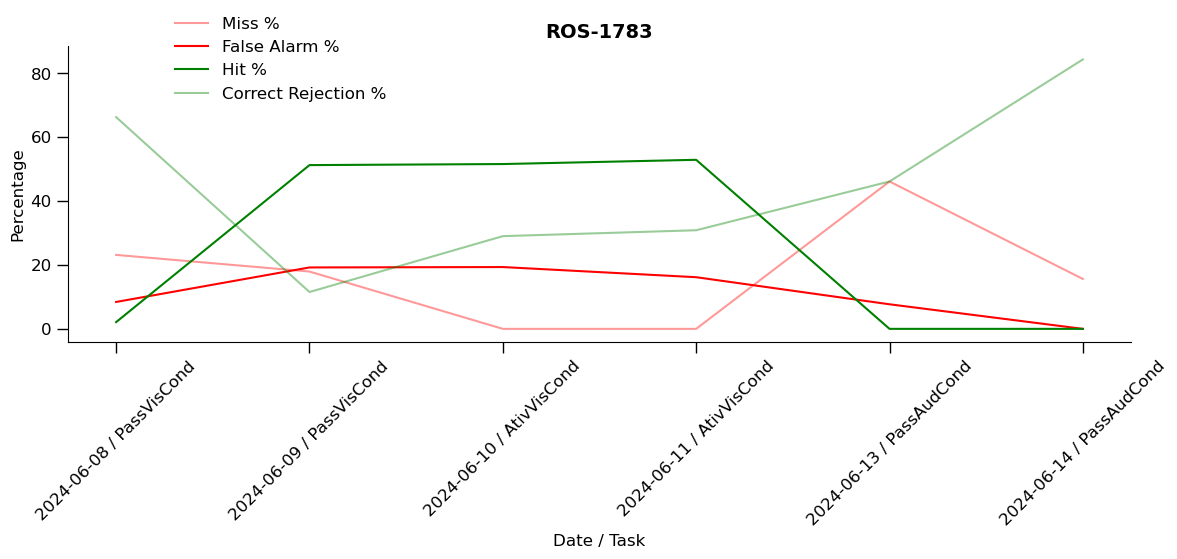

/tmp/ipykernel_1644387/1163683680.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


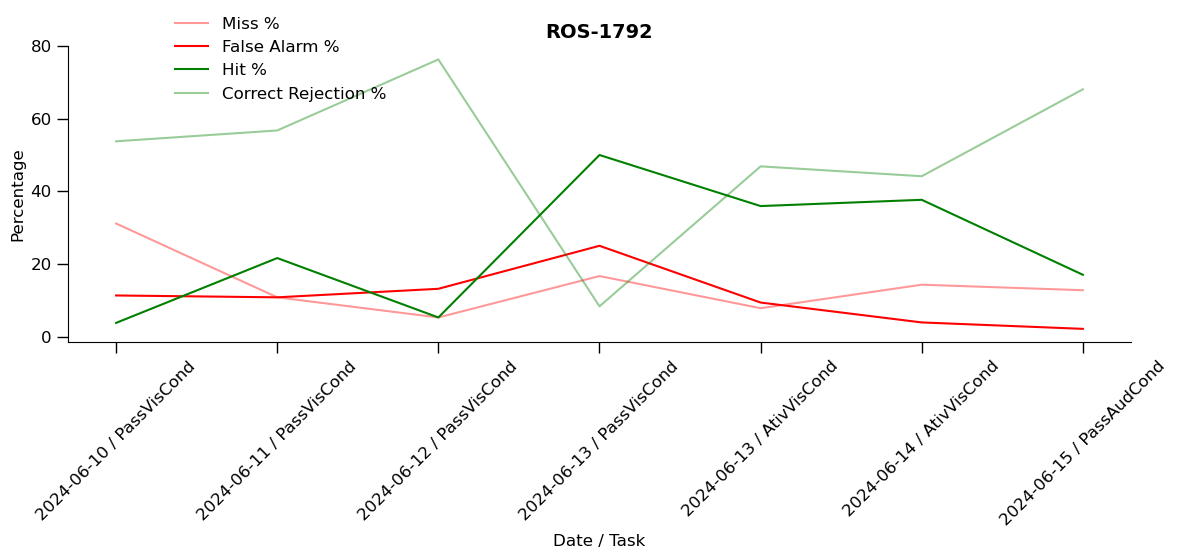

/tmp/ipykernel_1644387/1163683680.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


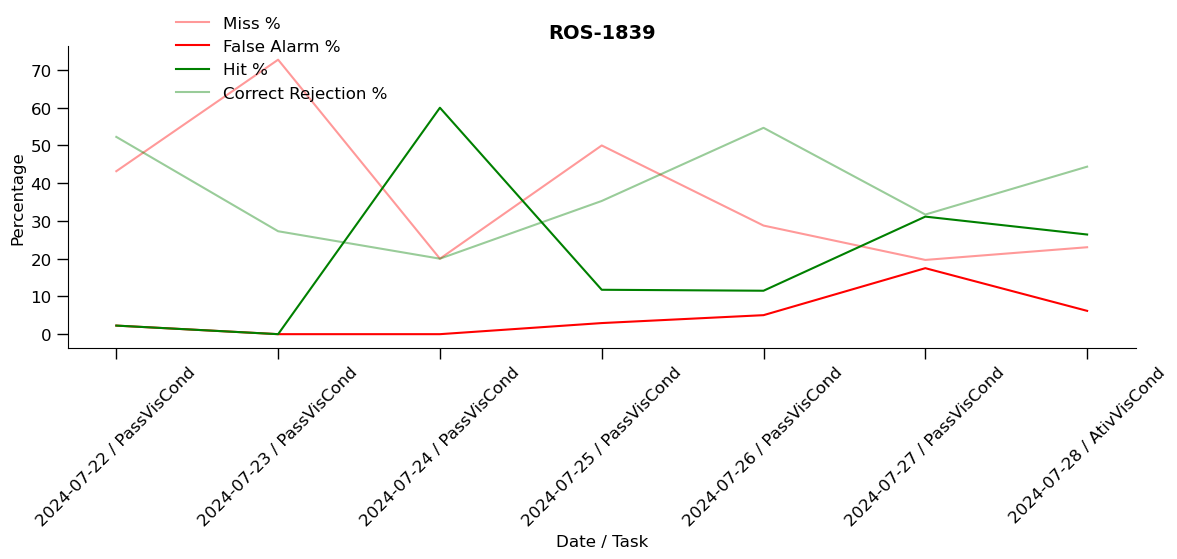

/tmp/ipykernel_1644387/1163683680.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


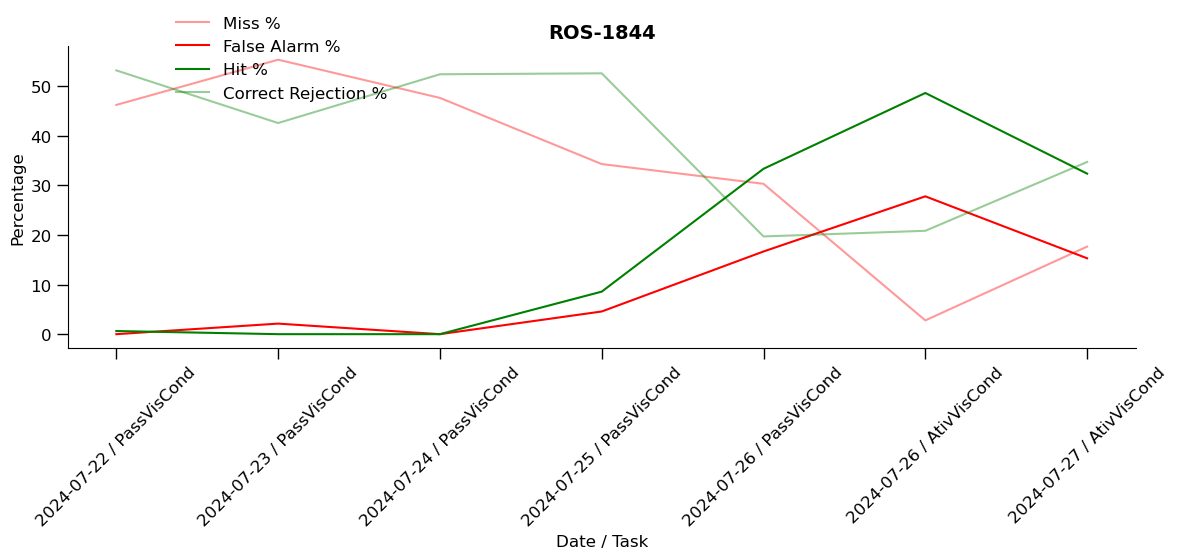

/tmp/ipykernel_1644387/1163683680.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


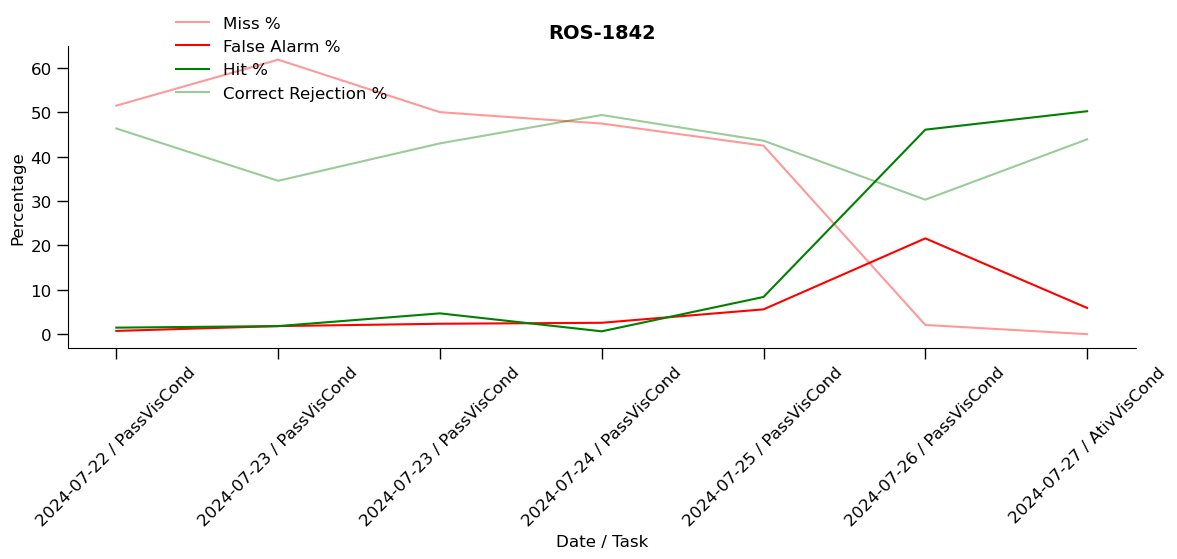

In [385]:
mice = learning_df['Mouse'].unique()
# Create a plot for each mouse
for mouse in mice:
    # Filter data for the current mouse
    mouse_data = learning_df[learning_df['Mouse'] == mouse]
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = "sans-serif"
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))  # This also creates an axis object 'ax' which you can use instead of plt directly
    ax.plot(mouse_data['Date_Task'], mouse_data['Miss %'], linestyle='-', label='Miss %', color = 'red', alpha=0.4)	
    ax.plot(mouse_data['Date_Task'], mouse_data['FA %'], linestyle='-', label='False Alarm %', color = 'red')
    ax.plot(mouse_data['Date_Task'], mouse_data['Hit %'], linestyle='-', label='Hit %', color = 'green')
    ax.plot(mouse_data['Date_Task'], mouse_data['CR %'], linestyle='-', label='Correct Rejection %', color = 'green', alpha=0.4)

    # Adding titles and labels
    ax.set_title(f'{mouse}')
    ax.set_xlabel('Date / Task')
    ax.set_ylabel('Percentage')
    ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability
    ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.2, 1.15))
    ax.tick_params(labelsize = 12)
    ax.grid(False)
    fig.tight_layout()

    # Construct the path to the folder where the plot will be saved
    folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
    file_path = os.path.join(folder_path, f'new_learning_curve_{mouse}')

    # Check if the folder exists, and create it if it does not
    # if not os.path.exists(folder_path):
    #     os.makedirs(folder_path)

    # Set the background color of the figure to white
    fig.patch.set_facecolor('white')

    # Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
    plt.savefig(f'{file_path}.pdf')
    # plt.savefig(f'{file_path}.png', bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()


# Outcome plot per session

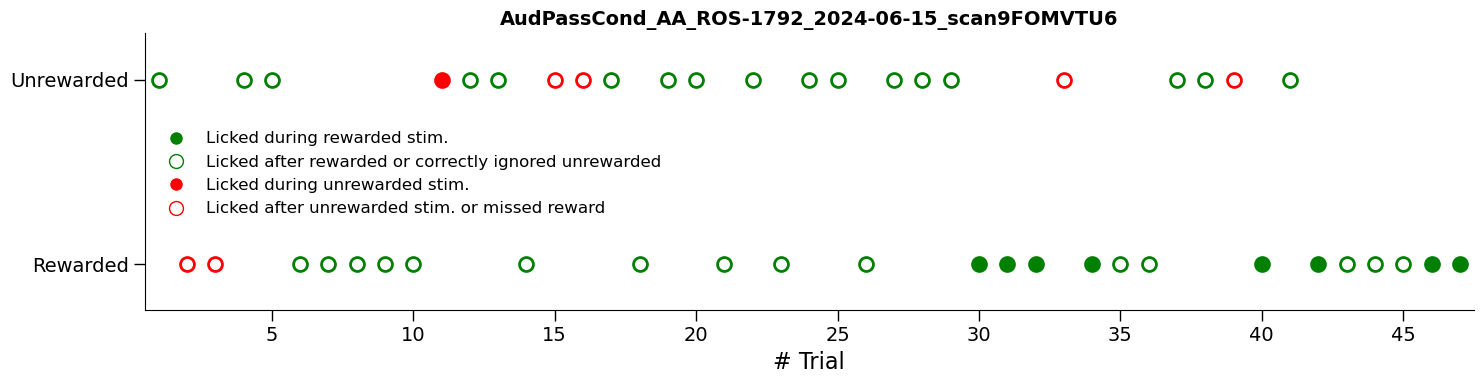

In [27]:
# Plotting setup
fig, ax = plt.subplots(figsize=(15, 4))  # Adjust the figsize to increase width and decrease height

# Define colors and markers based on outcome
color_map = { -1: 'red', 0: 'red', 1: 'green', 2: 'green' }
fill_style_map = { -1: 'none', 0: 'full', 1: 'full', 2: 'none' }

# Plot each point based on its outcome
for idx, row in outcome_df.iterrows():
    ax.plot(row['num_trial'], row['trial_type'], 'o',
            markerfacecolor=color_map[row['outcome']] if fill_style_map[row['outcome']] == 'full' else 'none',
            markeredgecolor=color_map[row['outcome']],
            markeredgewidth=2,
            markersize=10,
            fillstyle=fill_style_map[row['outcome']])

# Adjust y-axis
ax.set_yticks([1, 2])
ax.set_yticklabels(['Unrewarded', 'Rewarded'], fontsize=14)
ax.set_ylim(2.25, 0.75)  # Invert y-axis to place Type 1 on top

# Setting the axis labels and title
ax.set_xlabel('# Trial',fontsize=16)
# ax.set_ylabel('Trial Type')
ax.set_title(scan_info)  # Replace with your actual `scan_info` variable

# Adjust x-axis limits and spacing
ax.set_xlim(0.5, outcome_df['num_trial'].max() + 0.5)  # Provide a little padding
ax.tick_params(axis='x', labelsize=14)

# Create a custom legend using circle markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Licked during rewarded stim.',
           markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Licked after rewarded or correctly ignored unrewarded',
           markerfacecolor='none', markeredgecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Licked during unrewarded stim.',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Licked after unrewarded stim. or missed reward',
           markerfacecolor='none', markeredgecolor='red', markersize=10)
]

# Adjust legend position to avoid overlap and make it visually pleasant
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.4, 0.70), ncol=1, frameon=False)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


# Show the plot
plt.tight_layout()

# Construct the path to the folder where the plot will be saved
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Outcomes')
file_path = os.path.join(folder_path, f'{scan_info}_outcomes')

# Check if the folder exists, and create it if it does not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(f'{file_path}.svg')
plt.savefig(f'{file_path}.png')

plt.show()

# Outcome plot per training day

In [372]:
learning_df

,Mouse,Date,Task,True Task,Mode,Scan,Miss %,FA %,Hit %,CR %,Date_Task,Cohort,Training Day
0,ROS-1783,2024-06-08,PassVisCond,Visual Conditioning,Passive,scan9FOIPM7X,23.157895,8.421053,2.105263,66.315789,2024-06-08 / PassVisCond,1,1
1,ROS-1783,2024-06-09,PassVisCond,Visual Conditioning,Passive,scan9FOJAPFP,17.948718,19.230769,51.282051,11.538462,2024-06-09 / PassVisCond,1,2
2,ROS-1792,2024-06-10,PassVisCond,Visual Conditioning,Passive,scan9FOJVAWJ,31.132075,11.320755,3.773585,53.773585,2024-06-10 / PassVisCond,1,1
3,ROS-1783,2024-06-10,AtivVisCond,Visual Conditioning,Active,scan9FOJU4V9,0.000000,19.354839,51.612903,29.032258,2024-06-10 / AtivVisCond,1,3
4,ROS-1792,2024-06-11,PassVisCond,Visual Conditioning,Passive,scan9FOKEEYA,10.810811,10.810811,21.621622,56.756757,2024-06-11 / PassVisCond,1,2
5,ROS-1783,2024-06-11,AtivVisCond,Visual Conditioning,Active,scan9FOKFXB0,0.000000,16.176471,52.941176,30.882353,2024-06-11 / AtivVisCond,1,4
6,ROS-1792,2024-06-12,PassVisCond,Visual Conditioning,Passive,scan9FOKYJK6,5.263158,13.157895,5.263158,76.315789,2024-06-12 / PassVisCond,1,3
7,ROS-1792,2024-06-13,PassVisCond,Visual Conditioning,Passive,scan9FOLLVZB,16.666667,25.000000,50.000000,8.333333,2024-06-13 / PassVisCond,1,4
8,ROS-1792,2024-06-13,AtivVisCond,Visual Conditioning,Active,scan9FOLMDEP,7.812500,9.375000,35.937500,46.875000,2024-06-13 / AtivVisCond,1,4
9,ROS-1783,2024-06-13,PassAudCond,Auditory Conditioning,Passive,scan9FOLNSC0,46.153846,7.692308,0.000000,46.153846,2024-06-13 / PassAudCond,1,1
